In [71]:
# Učitavanje biblioteka

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
import statistics
from math import sqrt
from scipy import sparse

In [72]:
EPS = 0.000000003

In [73]:
# U nastavku su implementirane metode za user-based i item-based pristup
# i isprobane za različite vrednosti parametra k (broja suseda)

In [ ]:
# Učitavanje skupa podataka 

def loaddata(filename):
    df = pd.read_csv(f'{filename}.csv',sep=',',error_bad_lines=False, warn_bad_lines=False, encoding='latin-1')
    return df

data = loaddata('product_ratings')

In [75]:
data

,userId,itemId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [76]:
# Kreiranje matrice ocena

ratings_pivot_df = data.pivot(index='userId',columns='itemId',values='rating').fillna(0)
ratings_pivot_df.head()

itemId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Kreiranje retke matrice (Compressed Sparse Row matrix)

ratings_csr_matrix = sps.csr_matrix(ratings_pivot_df)
ratings_pivot_df.shape, print(ratings_csr_matrix.todense()) # toarray vraća ndarray; todense vraća matrix

[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


((610, 9724), None)

In [78]:
def sort_descending(li):
    """
    Funkcija za sortiranje liste opadajuće.
    
    Parametar:
    li: lista koja se sortira
    """
    li.sort(key = lambda x: x[0], reverse=True)
    return li

In [79]:
def get_prediction(ratings, similarity_matrix, cf_type, k = 5):
    """
    Funkcija za predviđanje ocena svih korisnika za sve stavke
    koja primenjuje user-based ili item-based pristup,
    zavisno od prosleđenog parametra.
    
    Parametri:
    ratings: matrica ocena
    similarity_matrix: matrica sličnosti
    cf_type: tip - zasnovano na korisnicima ili stavkama
    k: broj suseda
    """
    predictions = np.zeros(ratings.shape)
    
    if cf_type == 'user':
        
        for u in range(ratings.shape[0]):
            # print('Predvidjanje ocene za korisnika u = ', u)
            for i in range(ratings.shape[1]):
                # print('Predvidjanje ocene za korisnika u = {} i stavku i = {}.'.format(u, i))
                predictions[u,i] = user_based_ratings_prediction(u, i, similarity_matrix , ratings, k)
                
    elif cf_type == 'item':
        
        for u in range(ratings.shape[0]):
            # print('Predvidjanje ocene za korisnika u = ', u)
            for i in range(ratings.shape[1]):
                # print('Predvidjanje ocene za korisnika u = {} i stavku i = {}.'.format(u, i))
                predictions[u,i] = item_based_ratings_prediction(u, i, similarity_matrix, ratings, k)
                
    else:
        print("Greška! Tip mora biti user ili item.")
        return

    return predictions


In [80]:
def split_train_test(ratings_csr_matrix, percentage):
    """
    Ova funkcija vrši podelu datog skupa podataka na skup za trening i skup za test
    tako što se iz datog skupa "uzima" procenat ocena koje se upisuju u test skup,
    a uklanjaju iz trening skupa.

    Parametri:
    ratings_csr_matrix: retka matrica ocena - skup podataka koji treba podeliti na trening i test skup
    percentage: broj koji predstavlja procenat ocena koje ulaze u test skup
    """
    test_ratings_number = percentage / 100
    print("Odnos ocena u skupu za testiranje: ", percentage, "%")
    print("Odnos ocena u skupu za treniranje: ", 100-percentage, "%")

    total_ratings = ratings_csr_matrix.toarray()

    dimensions_of_total_ratings = total_ratings.shape
    print("Ukupan broj korisnika: ", dimensions_of_total_ratings[0])
    print("Ukupan broj stavki: ", dimensions_of_total_ratings[1])

    test = np.zeros(dimensions_of_total_ratings)
    train = total_ratings.copy()

    nonzero_ratings_per_row = (total_ratings != 0).sum(1)
    print("Ukupan broj ne-nula ocena u svim redovima: \n", nonzero_ratings_per_row)
    
    for user in range(dimensions_of_total_ratings[0]):
        
        # indeksi ne-nula elemenata
        nonzero_test_ratings_per_user = int(np.ceil(test_ratings_number*nonzero_ratings_per_row[user]))
        
        test_ratings = np.random.choice(total_ratings[user, :].nonzero()[0], size = nonzero_test_ratings_per_user, replace = False)
        
        # ocene se izbacuju iz trening skupa (upisuju se nule na odabranim pozicijama)
        train[user, test_ratings] = 0

        # ubacuju se u test skup (upisuju se ocene iz polaznog skupa, koje su uklonjene iz trening skupa)
        test[user, test_ratings] = total_ratings[user, test_ratings]
        
    if (not(np.all((train * test) == 0))):
        print("Greška!")
    else:    
        return sps.csr_matrix(train),sps.csr_matrix(test)

In [81]:
def user_based_ratings_prediction(u, i, users_similarity, ratings, k = 5):
    """
    Funkcija koja računa ocenu korisnika u za stavku i na osnovu matrice sličnosti korisnika.

    Parametri:
    u: id korisnika
    i: id stavke
    users_similarity: matrica sličnosti korisnika
    ratings: matrica ocena
    k: broj suseda
    """    
    neighbors = []
    similarities = list(zip(users_similarity[u][:], range(users_similarity.shape[0])))

    similarities_sorted = sort_descending(similarities)
    
    # najslicnijih k
    for i in range(1, k + 1):
        neighbors.append(similarities_sorted[i][1])
    # print ("neighbors: ", neighbors)

    rated_by_u = ratings[u].nonzero()[1]
    # print("Ocenio korisnik u: ", rated_by_u)
    
    user_u_mean = 0
    arr = ratings[u, :].toarray()[0]
    user_u_mean = np.sum(arr)
        
    if len(rated_by_u) != 0:
        user_u_mean = user_u_mean / len(rated_by_u)
        
    numerator, denominator = 0.0, 0.0

    for v in neighbors:
        rated_by_v = ratings[v].nonzero()[1]
        user_v_mean = 0
        # user_v_mean = sum(ratings[v, :].toarray()[0])
            
        if len(rated_by_v) != 0:
            for i in rated_by_v:
                user_v_mean += ratings[v, i]
            
            user_v_mean = user_v_mean / len(rated_by_v)
      

        r_vi = ratings[v,i]
        numerator += users_similarity[u][v]*(r_vi - user_v_mean)
        denominator += users_similarity[u][v]
        
    return user_u_mean + numerator/denominator

In [82]:
def item_based_ratings_prediction(u, i, items_similarity, ratings, k = 5):        
    """
    Funkcija računa ocenu korisnika u za stavku i na osnovu matrice sličnosti stavki.

    Parametri:
    u: id korisnika
    i: id stavke
    items_similarity: matrica sličnosti stavki
    ratings: matrica ocena
    k: broj suseda
    """
    neighbors = []
    similarities = list(zip(items_similarity[i][:],range(items_similarity.shape[0])))
    similarities_sorted = sort_descending(similarities)
    
    for i in range(1,k+1):
        neighbors.append(similarities_sorted[i][1])
        
    rated_i = ratings[:, i].nonzero()[0]
        
    item_i_mean = 0
    item_i_mean = np.sum(ratings[:, i].toarray()[0])
    
    if len(rated_i) != 0:
        item_i_mean = item_i_mean / len(rated_i)
        
    numerator, denominator = 0.0, 0.0
        
    for j in neighbors:
        rated_j = ratings[:, j].nonzero()[0]
        item_j_mean = 0
        
        if len(rated_j) != 0:
            arr2 = ratings[:, j].toarray()[0]
            item_j_mean = np.sum(arr2)
            item_j_mean = item_j_mean / len(rated_j)
        
        r_uj = ratings[u,j]
        numerator += items_similarity[i][j]*(r_uj - item_j_mean)
        denominator += items_similarity[i][j]
        
    return item_i_mean + numerator/denominator

In [94]:
def get_prediction(ratings, similarity_matrix, cf_type, k = 5):
    """
    Funkcija za predviđanje ocena svih korisnika za sve stavke
    koja primenjuje user-based ili item-based pristup,
    zavisno od prosleđenog parametra.
    
    Parametri:
    ratings: matrica ocena
    similarity_matrix: matrica sličnosti
    cf_type: tip - zasnovano na korisnicima ili stavkama
    k: broj suseda
    """
    predictions = np.zeros(ratings.shape)
    
    if cf_type == 'user':
        
        for u in range(ratings.shape[0]):
            # print('Predvidjanje ocene za korisnika u = ', u)
            for i in range(ratings.shape[1]):
                # print('Predvidjanje ocene za korisnika u = {} i stavku i = {}.'.format(u, i))
                predictions[u,i] = user_based_ratings_prediction(u, i, similarity_matrix , ratings, k)
                
    elif cf_type == 'item':
        
        for u in range(ratings.shape[0]):
            # print('Predvidjanje ocene za korisnika u = ', u)
            for i in range(ratings.shape[1]):
                # print('Predvidjanje ocene za korisnika u = {} i stavku i = {}.'.format(u, i))
                predictions[u,i] = item_based_ratings_prediction(u, i, similarity_matrix, ratings, k)
                
    else:
        print("Greška! Tip mora biti user ili item.")
        return

    return predictions

In [95]:
def selection(train_and_validation, k_values, cf_type):
    """
    Funkcija vrši predviđanje ocena za sve korisnike i sve stavke
    za različite vrednosti parametra k (različit broj suseda).
    
    Parametri:
    train_and_validation: skup podataka
    k_values: lista sa brojevima suseda
    cf_type: tip - zasnovano na korisnicima ili stavkama
    """    
    print('k_values = ', k_values)
    train, validation = split_train_test(train_and_validation, 20)
    errors = np.array([])
    predictions_arr = np.array([])
    
    if cf_type == 'user':
        
        similarity = cosine_similarity(train) + EPS
        
        for k in k_values:
            print('k = ', k)
            predictions = get_prediction(train, similarity, 'user', k)
            error = np.sqrt(mean_squared_error(validation.toarray()[validation.nonzero()],predictions[validation.nonzero()]))
        
            errors = np.append(errors, error)
            predictions_arr = np.append(predictions_arr, predictions)
    else:
        
        similarity = cosine_similarity(train.T) + EPS
        
        for k in k_values:
            print('k = ', k)
            predictions = get_prediction(train, similarity, 'item', k)
            error = np.sqrt(mean_squared_error(validation.toarray()[validation.nonzero()],predictions[validation.nonzero()]))
            
            errors = np.append(errors, error)
            predictions_arr = np.append(predictions_arr, predictions)
        
    k_optimal = k_values[np.argmin(errors)]
    
    if cf_type == 'user':
        similarity = cosine_similarity(train_and_validation) + EPS
        predictions = get_prediction(train_and_validation, similarity, 'user', k_optimal)
        return errors, predictions
    else:
        similarity = cosine_similarity(train_and_validation.T) + EPS
        predictions = get_prediction(train_and_validation, similarity, 'item', k_optimal)
        return errors, predictions

In [85]:
def filter_users(train_and_validation, m):
    """
    Funkcija koja filtrira matricu ocena tako da ostaju redovi koji imaju više od m ne-nula elemenata.
    
    Parametri:
    train_and_validation: skup podataka
    m: broj ne-nula elemenata
    """
    xy = train_and_validation.toarray()
    xy_filtered_matrix = []
    for y in xy:
        sum = 0
        nz = np.count_nonzero(y)
        if (nz > m):
            xy_filtered_matrix.append(y)

    arr_shape = np.vstack(xy_filtered_matrix).shape
    filtered_arr = np.vstack(xy_filtered_matrix)
    
    return sps.csr_matrix(filtered_arr)


In [86]:
# S obzirom na to da je matrica ocena je retka, u obzir će biti uzeti redovi sa što više ocena (više od 700).

filtered_arr_sparse = filter_users(ratings_csr_matrix, m = 700)
print('Dimenzije filtrirane matrice su: ', filtered_arr_sparse.shape)

Dimenzije filtrirane matrice su:  (26, 9724)


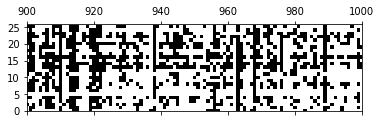

In [87]:
# Prikaz filtrirane matrice.

plt.spy(filtered_arr_sparse.toarray()) # na x osi su stavke (id)
# plt.axis('equal')
plt.xlim(900, 1000) # uzet je interval od 900 do 1000 za id stavke jer je prikaz previše sitan ako se obuhvate sve stavke
plt.ylim(0, filtered_arr_sparse.shape[0]) # broj korisnika
plt.show()

In [88]:
# Redukcija dimenzija matrice

ratings_csr_reduced = filtered_arr_sparse[:filtered_arr_sparse.shape[0], 900:1000]
print('Dimenzije redukovane matrice: ', ratings_csr_reduced.shape)

Dimenzije redukovane matrice:  (26, 100)


In [89]:
# Podedla skupa podataka

train_and_validation, test = split_train_test(ratings_csr_reduced, 30)

Odnos ocena u skupu za testiranje:  30 %
Odnos ocena u skupu za treniranje:  70 %
Ukupan broj korisnika:  26
Ukupan broj stavki:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [20 30 32 32 50  7 18 36 50 29 29 23 29 66 61 30 76 35 23 45 60 34 60 49
 26 32]


In [90]:
# Različite vrednosti suseda

k_values = [1, 2, 3, 4, 8, 10, 15, 20, 25]

In [91]:
# USER-BASED

errors_user, predictions_user = selection(train_and_validation, k_values, 'user')

k_values =  [1, 2, 3, 4, 8, 10, 15, 20, 25]
Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  26
Ukupan broj stavki:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [14 21 22 22 35  4 12 25 35 20 20 16 20 46 42 21 53 24 16 31 42 23 42 34
 18 22]
k =  1
k =  2
k =  3
k =  4
k =  8
k =  10
k =  15
k =  20
k =  25


In [92]:
# ITEM-BASED

errors_item, predictions_item = selection(train_and_validation, k_values, 'item')

k_values =  [1, 2, 3, 4, 8, 10, 15, 20, 25]
Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  26
Ukupan broj stavki:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [14 21 22 22 35  4 12 25 35 20 20 16 20 46 42 21 53 24 16 31 42 23 42 34
 18 22]
k =  1
k =  2
k =  3
k =  4
k =  8
k =  10
k =  15
k =  20
k =  25


### Evaluacija i zaključak

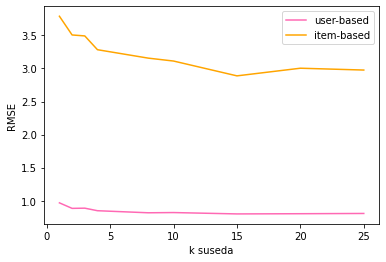

In [93]:
# Grafički prikaz RMSE prilikom predviđanja ocena koristeći user-based i item-based pristup

plt.plot(k_values, errors_user, color = 'hotpink', label = 'user-based')
plt.plot(k_values, errors_item, color = 'orange', label = 'item-based')
plt.legend(loc='best')
plt.xlabel('k suseda')
plt.ylabel('RMSE')
plt.show()

In [96]:
# User-based pristup daje bolje rezultate, s obzirom na to da je RMSE manja.